# **VISION TRANSFORMER**

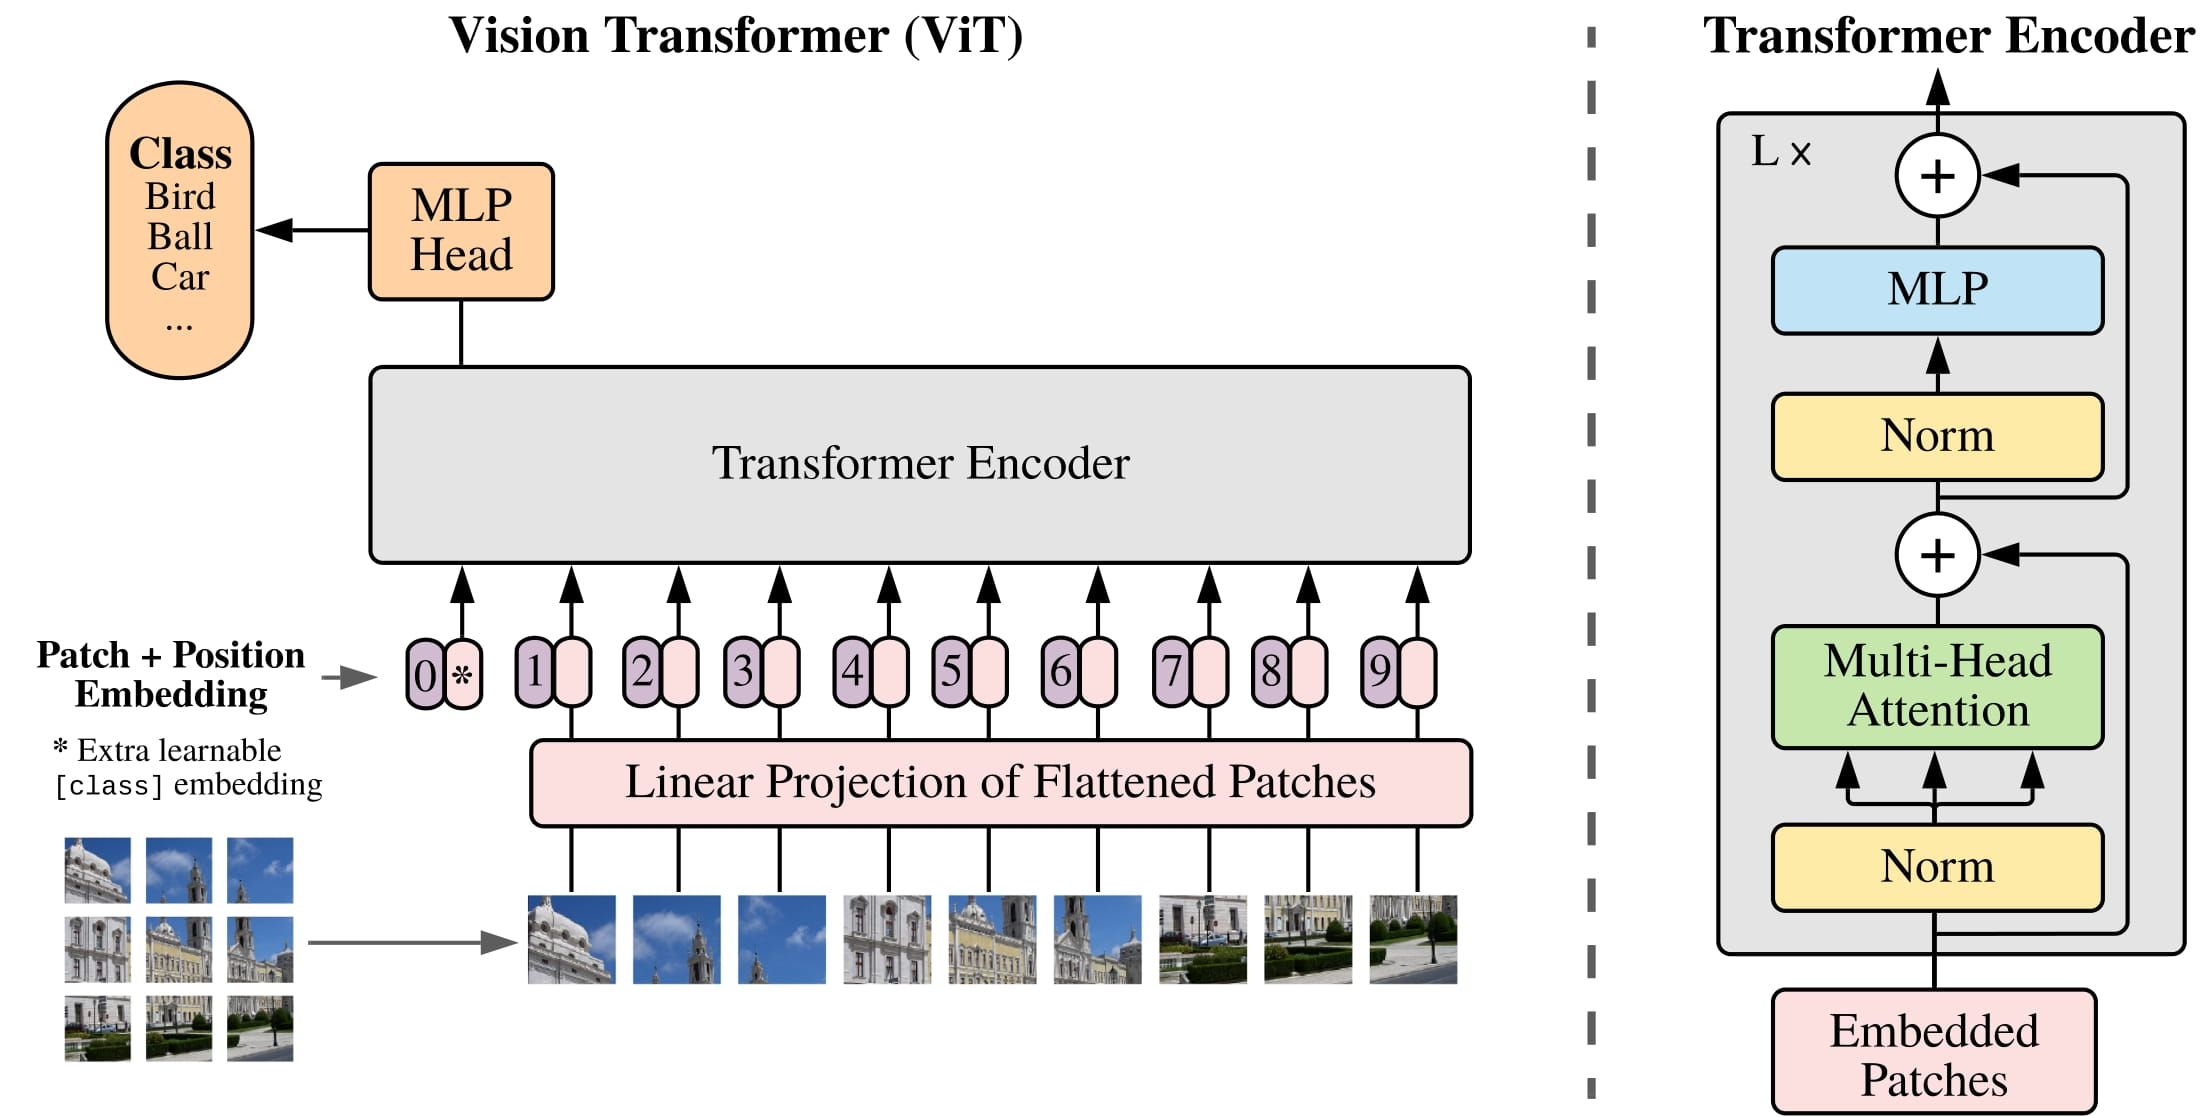

In [1]:
!pip install -q git+https://github.com/huggingface/transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 83.1 MB/s eta 0:00:00


In [ ]:
!unzip /content/drive/MyDrive/dataset/rock-paper-scissor.zip

In [10]:
import torchvision
from torchvision.transforms import ToTensor
import torch.utils.data as data

# **Data Preprocessing for all the sets**

In [4]:

data_transforms = {
    'train': torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# **Define the parameters for model training**

In [5]:
EPOCHS = 2
BATCH_SIZE = 10
LEARNING_RATE = 2e-5

# **Create the Train, Validation, Test Datasets**

In [6]:
train_ds = torchvision.datasets.ImageFolder('/content/train', transform=data_transforms['train'])

In [7]:
val_ds = torchvision.datasets.ImageFolder('/content/valid/', transform=data_transforms['val'])

In [8]:
test_ds = torchvision.datasets.ImageFolder('/content/test/', transform=data_transforms['test'])

# **Data Loaders**

In [11]:

train_loader = data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)

val_loader  = data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# ***WHY NOT THE INFINTE DATALOADER ?***

* Our model runs as per the number of epochs and the batch size 
* We can use the step size and run the training for the defined number of steps 

example :
  Epochs=4
  Batch size = 10 for 2500 examples (250)
  Step Size= 250*4 = 1000

  We can run the infinte dataloader for 1000 steps directly

# **Image Classification class with our forward function**

In [12]:
from transformers import ViTFeatureExtractor
import torch.nn as nn
import torch
from transformers import ViTModel
import torch.nn as nn
class ViTForImageClassification(nn.Module):
    def __init__(self, num_labels=3):
        super(ViTForImageClassification, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    def forward(self, pixel_values, labels, output_attentions = False):
        outputs = self.vit(pixel_values=pixel_values, return_dict = True)
        output = self.dropout(outputs.last_hidden_state[:,0])
        logits = self.classifier(output)
        attentions = outputs.attentions

        loss = None
        if labels is not None:
          loss_fct = nn.CrossEntropyLoss()
          loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        if loss is not None:
          return logits, loss.item(), attentions
        else:
          return logits, None, attentions

In [13]:
# Define Model
model = ViTForImageClassification(len(train_ds.classes))

In [14]:
# Feature Extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

/usr/local/lib/python3.8/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [15]:
# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [16]:
# Cross Entropy Loss
loss_func = nn.CrossEntropyLoss()

In [17]:
# Use GPU if available  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
if torch.cuda.is_available():
    model.cuda() 

In [18]:
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np

print("Number of train samples: ", len(train_ds))
print("Number of validation samples: ", len(val_ds))
print("Number of test samples: ", len(test_ds))
print("Detected Classes are: ", train_ds.class_to_idx)

Number of train samples:  2520
Number of validation samples:  372
Number of test samples:  33
Detected Classes are:  {'paper': 0, 'rock': 1, 'scissors': 2}


# **Model Training**

In [54]:

# Train the model
for epoch in range(EPOCHS):        
  for step, (x, y) in enumerate(train_loader):
    # Change input array into list with each batch being one element
    x = np.split(np.squeeze(np.array(x)), BATCH_SIZE)
    # Remove unecessary dimension
    for index, array in enumerate(x):
      x[index] = np.squeeze(array)
    # Apply feature extractor, stack back into 1 tensor and then convert to tensor
    x = torch.tensor(np.stack(feature_extractor(x)['pixel_values'], axis=0))
     # Send to GPU if available
    x, y  = x.to(device), y.to(device)
    b_x = Variable(x)   # batch x (image)
    b_y = Variable(y)   # batch y (target)
    # Feed through model
    output, loss, _ = model(b_x, None)
    # Calculate loss
    if loss is None: 
      loss = loss_func(output, b_y)   
      optimizer.zero_grad()           
      loss.backward()                 
      optimizer.step()

    if step % 50 == 0:
      # Get the next batch for testing purposes
      validation = next(iter(val_loader))
      val_x = validation[0]
      # Reshape and get feature matrices as needed
      val_x = np.split(np.squeeze(np.array(val_x)), BATCH_SIZE)
      for index, array in enumerate(val_x):
        val_x[index] = np.squeeze(array)
      val_x = torch.tensor(np.stack(feature_extractor(val_x)['pixel_values'], axis=0))
      # Send to appropirate computing device
      val_x = val_x.to(device)
      val_y = validation[1].to(device)
      # Get output (+ respective class) and compare to target
      val_output, loss, _ = model(val_x, val_y)
      val_output = val_output.argmax(1)
      # Calculate Accuracy
      accuracy = (val_output == val_y).sum().item() / BATCH_SIZE
      print('Epoch: ', epoch, '| train loss: %.4f' % loss, '| validation accuracy: %.2f' % accuracy)

Epoch:  0 | train loss: 1.0314 | validation accuracy: 0.60
Epoch:  0 | train loss: 0.6879 | validation accuracy: 1.00
Epoch:  0 | train loss: 0.5138 | validation accuracy: 1.00
Epoch:  0 | train loss: 0.3590 | validation accuracy: 1.00
Epoch:  0 | train loss: 0.4060 | validation accuracy: 0.90
Epoch:  0 | train loss: 0.3553 | validation accuracy: 0.90
Epoch:  1 | train loss: 0.1409 | validation accuracy: 1.00
Epoch:  1 | train loss: 0.4377 | validation accuracy: 0.80
Epoch:  1 | train loss: 0.2360 | validation accuracy: 0.90
Epoch:  1 | train loss: 0.1352 | validation accuracy: 1.00
Epoch:  1 | train loss: 0.6538 | validation accuracy: 0.70
Epoch:  1 | train loss: 0.0792 | validation accuracy: 1.00


torch.Size([1, 3, 224, 224])
torch.Size([1])


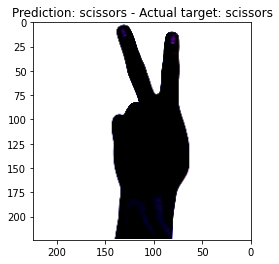

In [56]:
import matplotlib.pyplot as plt
import numpy as np
# Disable grad
test_loader  = data.DataLoader(test_ds, batch_size=1, shuffle=True, num_workers=4)
with torch.no_grad():
  inputs, target = next(iter(test_loader))
  # Reshape and get feature matrices as needed
  print(inputs.shape)
  print(target.shape)
  inputs = inputs[0].permute(1, 2, 0)
  # Save original Input
  originalInput = inputs
  for index, array in enumerate(inputs):
    inputs[index] = np.squeeze(array)
  inputs = torch.tensor(np.stack(feature_extractor(inputs)['pixel_values'], axis=0))

  # Send to appropriate computing device
  inputs = inputs.to(device)
  target = target.to(device)
 
  # Generate prediction
  prediction, loss, _ = model(inputs, target)
    
  # Predicted class value using argmax
  predicted_class = np.argmax(prediction.cpu())
  value_predicted = list(test_ds.class_to_idx.keys())[list(test_ds.class_to_idx.values()).index(predicted_class)]
  value_target = list(test_ds.class_to_idx.keys())[list(test_ds.class_to_idx.values()).index(target)]
        
  # Show result
  plt.imshow(originalInput)
  plt.xlim(224,0)
  plt.ylim(224,0)
  plt.title(f'Predicted Class: {value_predicted}\nActual target: {value_target}')
  plt.show()

# ***HYPERPARAMETER TUNING:***
1. Learning rate, Batch Size, number of epochs, dropout rate
2. Define a search space for hyperparameter tuning - example [0.001, 0.01, 0.1] is the search space for learning rate 
3. Use Search Method - Grid Search, Random Search


# ***VISION TRANSFORMERS FOR DETECTION OF TEXTURED AREAS***
1. Dataset with textured images and with diverse images (different backgrounds, lighting and angles)
2. Data Preprocessing: Label the dataset with the texture present
3. Data augmentation techniques to increase the size of dataset
4. Use attention maps to investigate further on the wrongly classified images and retrain the model with those images 

# **ATTENTION MAPS**

In [65]:
# with torch.no_grad():
  
inputs, target = next(iter(test_loader))
# Reshape and get feature matrices as needed
print(inputs.shape)
print(target.shape)
inputs = inputs[0].permute(1, 2, 0)
# Save original Input
originalInput = inputs
for index, array in enumerate(inputs):
  inputs[index] = np.squeeze(array)
inputs = torch.tensor(np.stack(feature_extractor(inputs)['pixel_values'], axis=0))

# Send to appropriate computing device
inputs = inputs.to(device)
target = target.to(device)

# Generate prediction
output, _, attentions  = model(inputs, target, output_attentions=True)

# Get attention maps for final layer
attention_maps = attentions[-1] # Get last layer and last attention head
# Resize image and attention maps to original size
image = torchvision.transforms.Resize((224, 224))(inputs.squeeze(0))
attention_maps = torchvision.transforms.Resize((224, 224))(attention_maps)

# Plot image and attention maps
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
axs[0].imshow(image.permute(1, 2, 0))
axs[0].set_title('Image')

for i, ax in enumerate(axs[1:]):
    # Plot attention map for ith patch
    ax.imshow(attention_maps[i], cmap='gray')
    ax.set_title(f'Attention Map {i+1}')

plt.show()

torch.Size([1, 3, 224, 224])
torch.Size([1])


AttributeError: ignored

In [ ]:
attentions

In [ ]:
model_vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

In [ ]:
model_vit = model_vit.to(device)

In [ ]:
output = model_vit(pixel_values = inputs, output_attentions = True, return_dict = True)

In [ ]:
output.keys()

In [ ]:
output.attentions